In [62]:
from QHyper.problems.workflow_scheduling import (
    Workflow,
    WorkflowSchedulingProblem,
)

In [63]:
tasks_file =  "workflows_data/workflows/4_tasks_3_machines_2_paths.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 20

In [64]:
workflow = Workflow(tasks_file, machines_file, deadline)

In [65]:
workflow.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task2,6.0,2.0,4.0
Task3,12.0,4.0,8.0
Task4,24.0,8.0,16.0


In [66]:
workflow.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task2,6.0,8.0,8.0
Task3,12.0,16.0,16.0
Task4,24.0,32.0,32.0


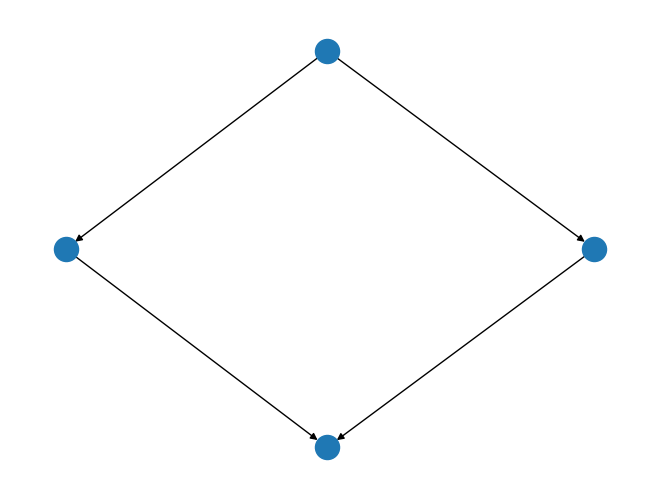

In [67]:
# Requires pygraphviz
# apt install -q libgraphviz-dev
# pip install -q pygraphviz
# pip install -q pydot
workflow.wf_instance.draw()

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

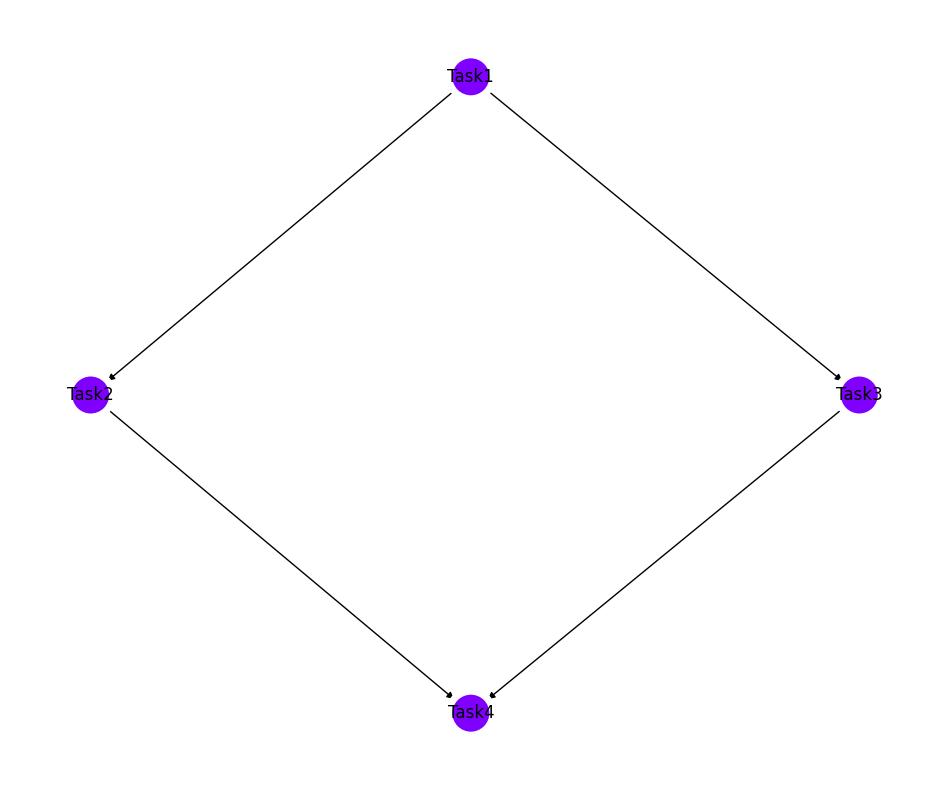

In [68]:
# Prettier way to draw workflow
import wfcommons.wfchef.utils as utils

utils.draw(workflow.wf_instance.workflow, with_labels=True)

In [69]:
import numpy as np
from wfcommons.common.task import Task, TaskType
from wfcommons.common.machine import Machine
from wfcommons.common.workflow import Workflow as WfWorkflow

In [70]:
def calc_rank_up(workflow: Workflow, task, rank, mean_times):
    if task in rank:
        return rank[task]
    children = workflow.wf_instance.workflow.tasks_children[task]
    max_child_rank = max([calc_rank_up(workflow, child, rank, mean_times) for child in children]) if children else 0
    rank[task] = mean_times[task] + max_child_rank
    return rank[task]

def select_split_chunks(rank_up, n_parts):
    sorted_tasks = sorted(rank_up, key = rank_up.get, reverse=True)
    return np.array_split(sorted_tasks, n_parts)

def select_split_chunks_enhanced(rank_up: dict, n_parts: int, mean_times: dict) -> list:
    summary_mean_times = sum(mean_times.values())
    sum_points = [summary_mean_times/n_parts * i for i in range(1, n_parts)]
    current_point = 0
    current_sum = 0.0
    parts = []
    part = []
    sorted_tasks = sorted(rank_up, key = rank_up.get, reverse=True)
    for task in sorted_tasks:
        print(f"Task: {task}, his rank, sum_points = {sum_points}, current_point = {current_point}, current_sum = {current_sum}")
        if mean_times[task] + current_sum < sum_points[current_point]:
            part.append(task)
        else:
            parts.extend(part)
            part = []
            part.append(task)
            current_point += 1
        current_sum += mean_times[task]
    return parts

def create_subworkflow(parent_workflow: WfWorkflow, tasks: list, name: str) -> WfWorkflow:
    subworkflow = WfWorkflow(
        name=f"workflow{name}"
    )
    for task in tasks:
        subworkflow.add_task(parent_workflow.tasks[task])
    for task in tasks:
        for parent in filter(lambda p: p in tasks, parent_workflow.tasks_parents[task]):
            subworkflow.add_dependency(parent, task)
    return subworkflow

def artificial_machine():
    return Machine(
        name = "Artificial machine",
        cpu = {
            "speed": 1,
            "count": 1
        }
    )
        
def create_subworkflows(workflow: Workflow, parts: list) -> list:
    wfworkflow = workflow.wf_instance.workflow
    subworkflows = []
    for pair_id, pair in enumerate(zip(parts[:-1], parts[1:])):
        part1, part2 = pair
        connecting_task = Task(
            name=f"Task{pair_id}_{pair_id + 1}",
            task_type=TaskType.COMPUTE,
            runtime=0,
            cores=1,
            machine=artificial_machine()
        )
        
        workflow1 = create_subworkflow(wfworkflow, part1, f"subworkflow{pair_id}")
        workflow1_leafs = workflow1.leaves()
        workflow1.add_task(connecting_task)
        for leaf in workflow1_leafs:
            workflow1.add_dependency(leaf, connecting_task.name)
            
        workflow2 = create_subworkflow(wfworkflow, part2, f"subworkflow{pair_id + 1}")
        workflow2_roots = workflow2.roots()
        workflow2.add_task(connecting_task)
        for root in workflow2_roots:
            workflow2.add_dependency(connecting_task.name, root)
        
        subworkflows.extend([workflow1, workflow2])
            
    return subworkflows

def decompose(workflow: Workflow, n_parts = 2) -> list:
    mean_times = workflow.time_matrix.mean(axis = 1).to_dict()
    rank_up = {}
    
    first_task = workflow.wf_instance.roots()[0]
    
    calc_rank_up(workflow, first_task, rank_up, mean_times)
    split_chunks = select_split_chunks(rank_up, n_parts)
    # split_chunks = select_split_chunks_enhanced(rank_up, n_parts, mean_times)
    
    return create_subworkflows(workflow, split_chunks)

In [71]:
workflow1, workflow2 = decompose(workflow, 2)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

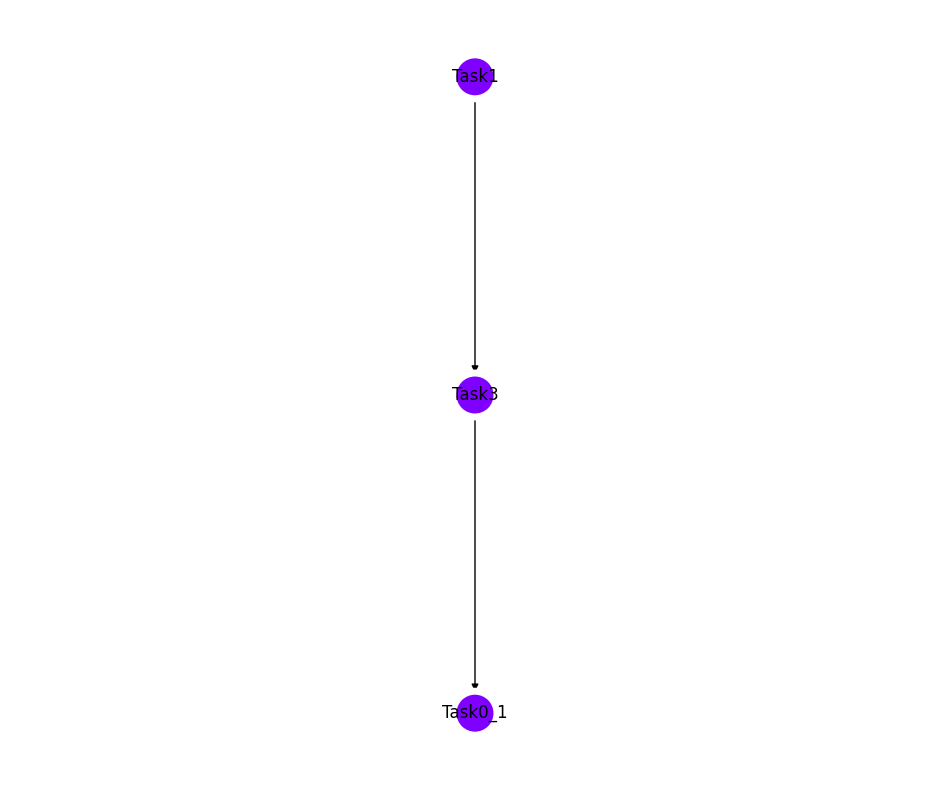

In [72]:
utils.draw(workflow1, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

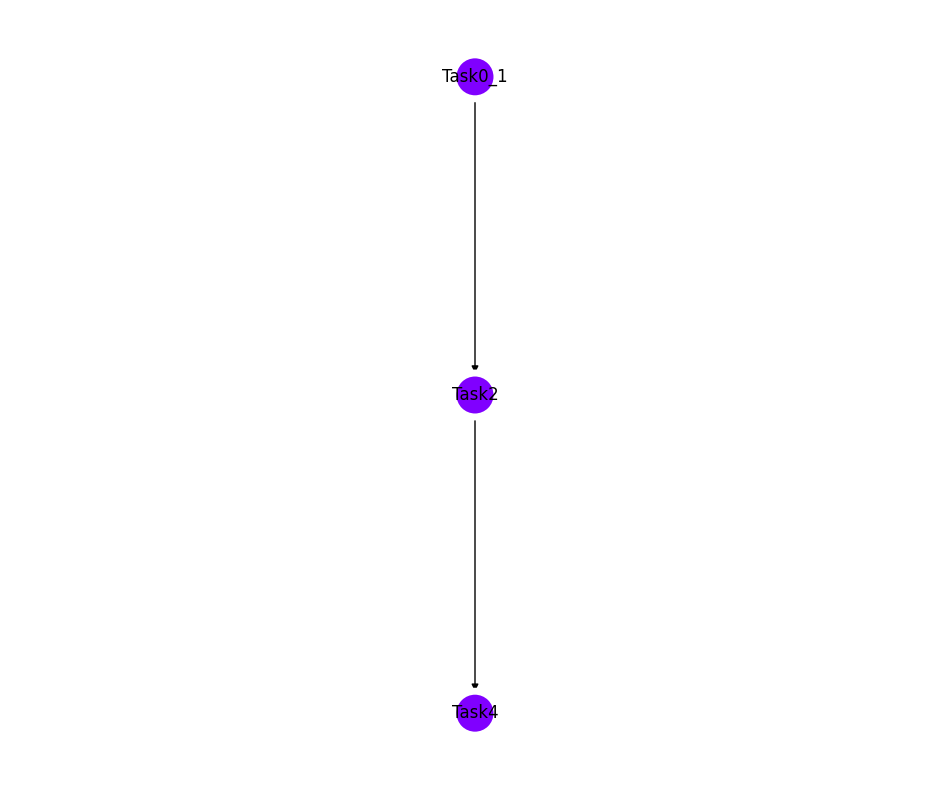

In [73]:
utils.draw(workflow2, with_labels=True)

In [74]:
from copy import copy

def merge_subworkflows(subworkflows: list) -> WfWorkflow:
    workflow = WfWorkflow(name = "merged")
    for idx, subworkflow in enumerate(subworkflows):
        for task in subworkflow.tasks.values():
            task_copy = copy(task)
            if "_" in task_copy.name:
                task_copy.category = "connection"
            else:
                task_copy.category = f"{idx}"
            workflow.add_task(task_copy)
    for subworkflow in subworkflows:
        for task in subworkflow.tasks.keys():
            for parent in subworkflow.tasks_parents[task]:
                workflow.add_dependency(parent, task)
    return workflow

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

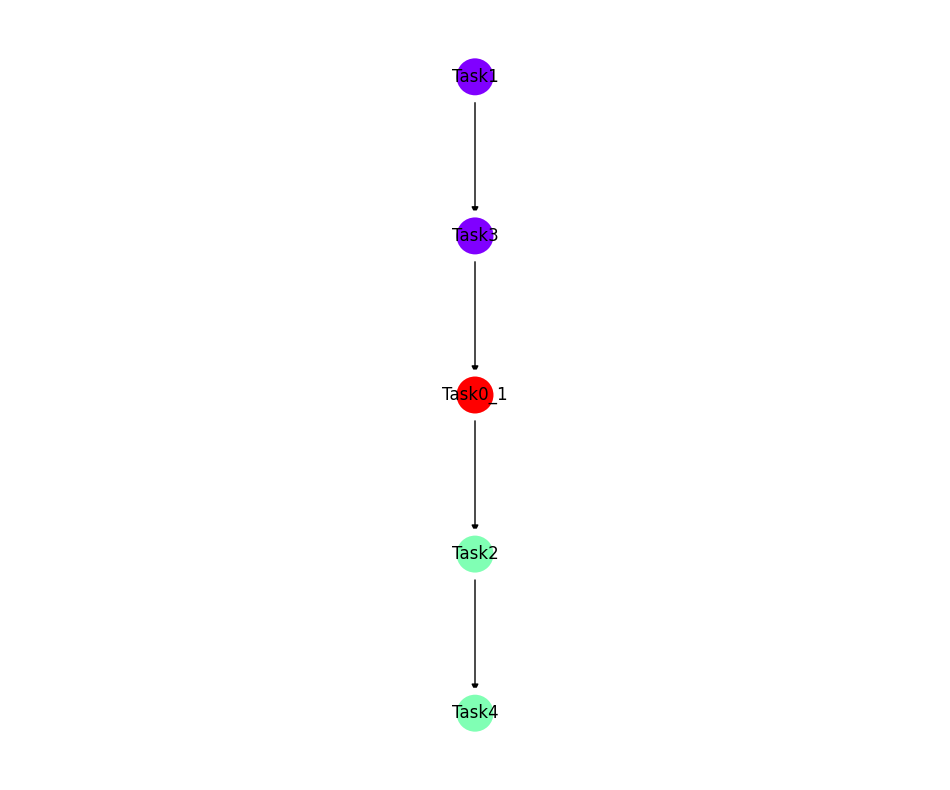

In [75]:
merged = merge_subworkflows([workflow1, workflow2])
utils.draw(merged, with_labels=True)

In [76]:
import tempfile
import pathlib

def wfworkflow_to_qhyper_workflow(workflow: WfWorkflow, machines_file: str, deadline: float) -> Workflow:
    with tempfile.NamedTemporaryFile() as temp:
        workflow.write_json(pathlib.Path(temp.name))
        return Workflow(pathlib.Path(temp.name), machines_file, deadline)

In [77]:
workflow1 = wfworkflow_to_qhyper_workflow(workflow1, machines_file, deadline/2)
workflow2 = wfworkflow_to_qhyper_workflow(workflow2, machines_file, deadline/2)

In [78]:
workflow1.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task3,12.0,4.0,8.0
Task0_1,0.0,0.0,0.0


In [79]:
workflow1.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task3,12.0,16.0,16.0
Task0_1,0.0,0.0,0.0


In [80]:
workflow2.time_matrix

,MachineA,MachineB,MachineC
Task2,6.0,2.0,4.0
Task4,24.0,8.0,16.0
Task0_1,0.0,0.0,0.0


In [81]:
workflow2.cost_matrix

,MachineA,MachineB,MachineC
Task2,6.0,8.0,8.0
Task4,24.0,32.0,32.0
Task0_1,0.0,0.0,0.0


# Example with more complex workflow

In [82]:
tasks_file =  "workflows_data/workflows/complex_workflow.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50

In [83]:
workflow = Workflow(tasks_file, machines_file, deadline)

In [84]:
workflow.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task2,6.0,2.0,4.0
Task3,6.0,2.0,4.0
Task4,6.0,2.0,4.0
Task5,6.0,2.0,4.0
Task6,6.0,2.0,4.0
Task7,9.0,3.0,6.0
Task8,9.0,3.0,6.0
Task9,9.0,3.0,6.0
Task10,12.0,4.0,8.0


In [85]:
workflow.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task2,6.0,8.0,8.0
Task3,6.0,8.0,8.0
Task4,6.0,8.0,8.0
Task5,6.0,8.0,8.0
Task6,6.0,8.0,8.0
Task7,9.0,12.0,12.0
Task8,9.0,12.0,12.0
Task9,9.0,12.0,12.0
Task10,12.0,16.0,16.0


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

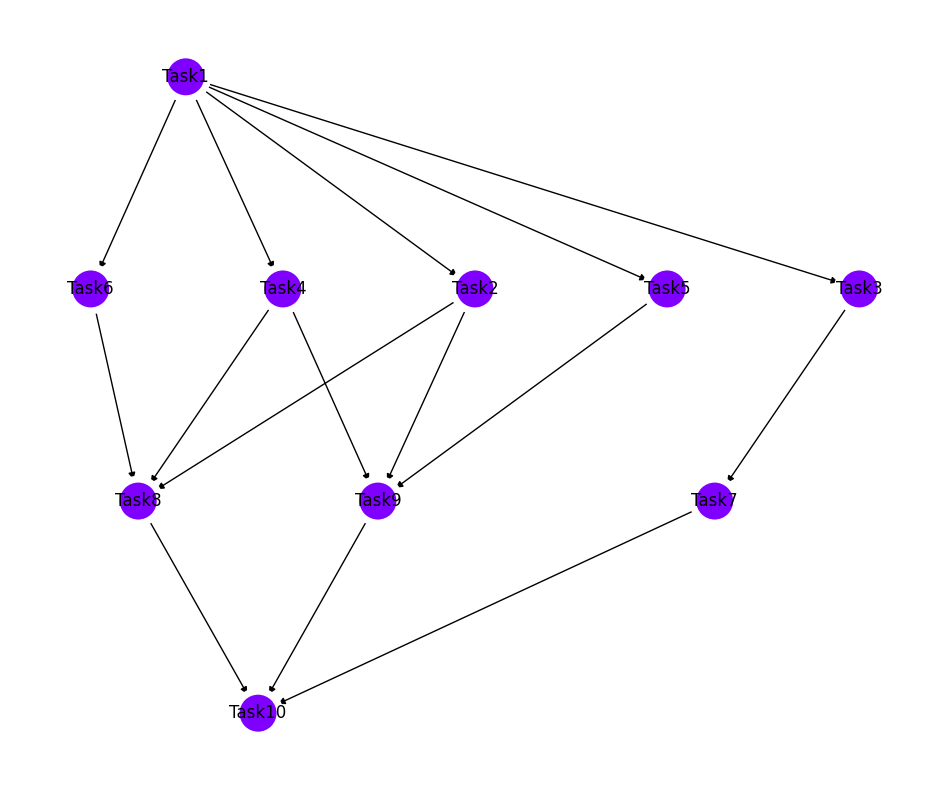

In [86]:
utils.draw(workflow.wf_instance.workflow, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

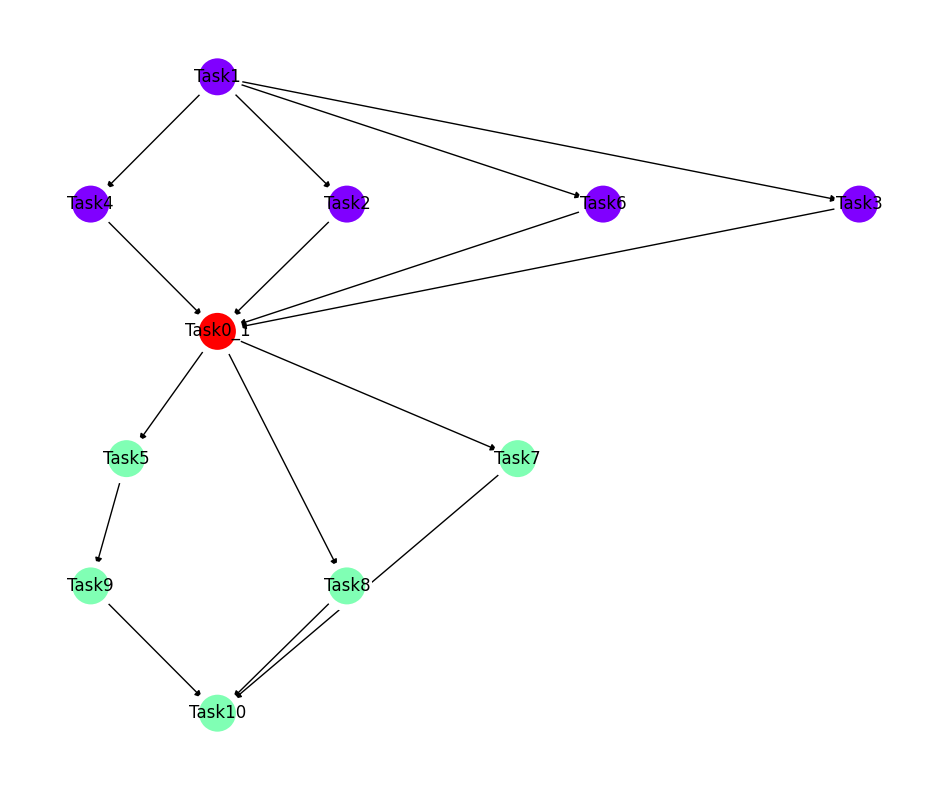

In [87]:
workflow1, workflow2 = decompose(workflow, 2)
merged = merge_subworkflows([workflow1, workflow2])
utils.draw(merged, with_labels=True)